# SharinGAN Notebook

Please note this is a "lite" version of the code created on Google Colab, only to showcase the architecture and working.

This means:

* This code runs completely.

* Training is done only for a few epochs and on very limited data - just there to show "it works".

* Testing is done with a *pretrained network* and on just 5 images. The output images are displayed as well.

We trained this network on a machine with an NVIDIA TITAN X GPU for 300 epochs on 80% of the entire dataset (~900 images). Testing was performed on the held back 20% (~250 images).

Please contact **chatt086@**, **jakku004@**, **buddh009@** or **vaidy083@** if you have any questions.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1FxxjLtm-C_2c5H8ZNQLg8vV92E4-VKPn'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_train.tgz')
file_id = '1S4SxG1O_VqaZgnLEdKD2kErmEGGWd29g'
test = drive.CreateFile({'id': file_id})
test.GetContentFile('bed.tgz')
checkpoint_gen = '19UeUz9Y145Ji-WmqqsGSqAA-mLymVTRL'
dcheck_gen = drive.CreateFile({'id': checkpoint_gen})
dcheck_gen.GetContentFile('latest_net_G.pth')
checkpoint_dis = '14SixJ6BCeFeBDypnK0yLbcacGj6_WJh5'
dcheck_dis = drive.CreateFile({'id': checkpoint_dis})
dcheck_dis.GetContentFile('latest_net_D.pth')
!tar -xzf test_train.tgz
!tar -zxf bed.tgz

In [0]:
# Check if the dataset is loaded. 
!ls bed

_0_0.JPG  _0_2.JPG  _1_0.JPG  _1_2.JPG	_2_0.JPG  _2_2.JPG  _3_0.JPG  _3_2.JPG
_0_1.JPG  _0_3.JPG  _1_1.JPG  _1_3.JPG	_2_1.JPG  _2_3.JPG  _3_1.JPG  _3_3.JPG


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install --no-cache-dir -I pillow

tcmalloc: large alloc 1073750016 bytes == 0x589e4000 @  0x7fa69f1892a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 2.0MB 36.0MB/s 


In [0]:
import torch
import os
import torch.nn as nn
from torch.nn import init
import functools
import torch.autograd as autograd
import numpy as np
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
import random

# Data Pre-Processing and Loading

In [0]:
class AlignedDataSet(torch.utils.data.Dataset):
  def __init__(self):
    super(AlignedDataSet, self).__init__()

  def name(self):
    return 'AlignedDataSet'

  def __len__(self):
    return len(self.AB_paths)

  def initialize(self, path, phase):
    self.transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                    (0.5, 0.5, 0.5))])
    folder = os.path.join(path, phase)
    self.AB_paths = sorted(make_dataset(folder))


  def __getitem__(self, index):
    AB_path = self.AB_paths[index]
    image = self.AB_paths[index]
    AB = Image.open(AB_path).convert('RGB')
    AB = AB.resize((640 * 2, 360), Image.BICUBIC)
    AB = self.transform(AB)

    # randomly crop
    w_total = AB.size(2)
    w = int(w_total / 2)
    h = AB.size(1)
    w_offset = random.randint(0, max(0, w - 256 - 1))
    h_offset = random.randint(0, max(0, h - 256 - 1))

    A = AB[:, h_offset:h_offset + 256,
           w_offset:w_offset + 256]
    B = AB[:, h_offset:h_offset + 256,
           w + w_offset:w + w_offset + 256]

    if random.random() < 0.5:
        # randomly flip the images
        idx = [i for i in range(A.size(2) - 1, -1, -1)]
        idx = torch.LongTensor(idx)
        A = A.index_select(2, idx)
        B = B.index_select(2, idx)

    return {'A': A, 'B': B,
            'A_paths': AB_path, 'B_paths': AB_path}

    
class SingleImageDataset(torch.utils.data.Dataset):
  def __init__(self):
    super(SingleImageDataset, self).__init__()

  def initialize(self, path, phase):
    folder = os.path.join(path, phase, 'blurred')

    self.A_paths = sorted(make_dataset(folder))

    self.transform = transforms.Compose([
        transforms.Resize([640, 360], Image.BICUBIC),
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ])

  def __getitem__(self, index):
    A_path = self.A_paths[index]

    A_img = Image.open(A_path).convert('RGB')

    A_img = self.transform(A_img)

    return {'A': A_img, 'A_paths': A_path}

  def __len__(self):
    return len(self.A_paths)

  def name(self):
    return 'SingleImageDataset'

def make_dataset(folder):
  images = []
  assert os.path.isdir(folder), '%s is not a valid directory' % folder
  IMG_EXTENSIONS = [
      '.jpg', '.JPG', '.jpeg', '.JPEG',
      '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
  ]

  for root, _, fnames in sorted(os.walk(folder)):
    for fname in fnames:
      if any(fname.endswith(extension) for extension in IMG_EXTENSIONS):
        path = os.path.join(root, fname)
        images.append(path)

  return images


train_dataset = AlignedDataSet()
train_dataset.initialize('test_train', 'train')
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=1,
                                                shuffle=True)

test_dataset = SingleImageDataset()
test_dataset.A_paths = sorted(make_dataset('bed'))
test_dataset.transform = transforms.Compose([
  transforms.Resize([640, 360], Image.BICUBIC),
  transforms.RandomCrop(256),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5),
                       (0.5, 0.5, 0.5))
])

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                batch_size=1,
                                                shuffle=True)

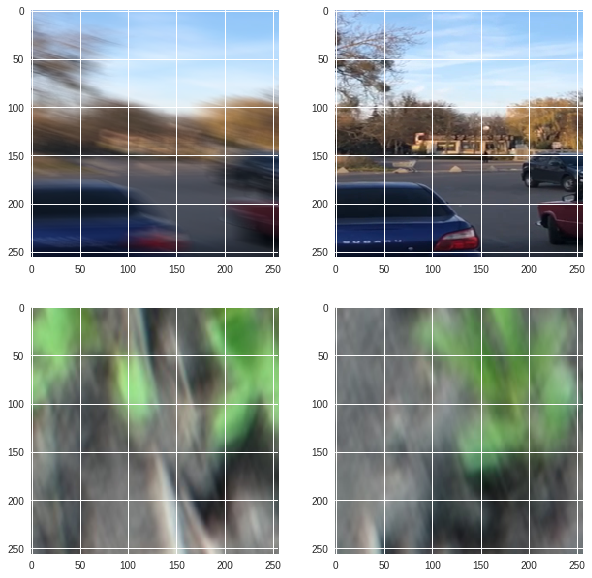

In [0]:
# test if dataloaders are working as expected
%matplotlib inline
import matplotlib.pyplot as plt

# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

train_iter = iter(train_dataloader)
train_data = next(train_iter)

# display the train blurred and sharp pair images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].set_label("Train A")
axes[0, 0].imshow(im_convert(train_data['A']))
axes[0, 1].set_label("Train B")
axes[0, 1].imshow(im_convert(train_data['B']))


test_iter = iter(test_dataloader)
test_data = next(test_iter)

# display a couple of test images
axes[1, 0].set_label("Test 1 A")
axes[1, 0].imshow(im_convert(test_data['A']))
test_data = next(test_iter)
axes[1, 1].set_label("Test 2 A")
axes[1, 1].imshow(im_convert(test_data['A']))

# Generator Architecture

The below classes define the Generator used in our GAN model.

We use a Resnet Generator network which is defined in the *ResnetGenerator* class.

The *ResnetGenerator* uses several *ResnetBlock*s defined appropriately in the *ResnetBlock* class.

In [0]:
# ResnetGenerator and Block from https://github.com/KupynOrest/DeblurGAN/blob/master/models/networks.py

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=9, gpu_ids=[], use_parallel = True, learn_residual = False, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpu_ids = gpu_ids
        self.use_parallel = use_parallel
        self.learn_residual = learn_residual
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        print(isinstance(input.data, torch.cuda.FloatTensor))
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor) and self.use_parallel:
            output = nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            output = self.model(input)
        if self.learn_residual:
            output = input + output
            output = torch.clamp(output,min = -1,max = 1)
        return output
      
      

class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


# Discriminator Architecture

In [0]:
#NLayerDiscriminator from : https://github.com/KupynOrest/DeblurGAN/blob/master/models/networks.py
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[], use_parallel = True):
        super(NLayerDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        self.use_parallel = use_parallel
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = int(np.ceil((kw-1)/2))
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor) and self.use_parallel:
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)


The below code is used to get the Generator and the Discriminator network defined above.

Further, a method to initialize the weights of the networks is provided as *weights_init()*

In [0]:
  '''
  The below method returns the ResnetGenerator that is used as the Generator
  network in our GAN.
  '''
  def getGenerator(input_nc, output_nc, ngf, gpu_ids=[], 
                   use_parallel = True, learn_residual = False):
    netGen = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)

    assert(torch.cuda.is_available())
    netGen = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, 
                           use_dropout=False, n_blocks=9, gpu_ids=gpu_ids, 
                           use_parallel=use_parallel, learn_residual = learn_residual)
    if use_gpu > 0:
		  netGen.cuda(gpu_ids[0])
    netGen.apply(weights_init)
    return netGen

  '''
  The below method returns the NLayerDiscriminator network that is used as the
  discriminator network.
  '''
  def getDiscriminator(input_nc, ndf,
               n_layers_D=3, use_sigmoid=False, 
               gpu_ids=[], use_parallel = True):
    netDis = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)

    assert(torch.cuda.is_available())
    netDis = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, 
                               use_sigmoid=use_sigmoid, gpu_ids=gpu_ids, use_parallel=use_parallel)

    if use_gpu > 0:
      netDis.cuda(gpu_ids[0])
    netDis.apply(weights_init)
    return netDis
 
  
  '''
  Method to initialize the weights of the network
  '''
  def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if hasattr(m.bias, 'data'):
            m.bias.data.fill_(0)
    elif classname.find('BatchNorm2d') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)

    return norm_layer

# Calculate Loss

The methods in this section are used to calculate the losses:


1.   Adversarial Loss
2.   Perceptual Loss

The discriminator network uses only the Adversarial Loss to update its weights, while the generator network uses both the Adverserial Loss as well as the Perceptual Loss to update the weights.

Since we use WGAN-GP, we use Gradient Penalty in calculating our loss.


In [0]:
'''
Get the VGG-19 model upto a perticular number('layer_num') of layers.
'''
def getVggLayer(layer_num):
  cnn = models.vgg19(pretrained=True).features
  cnn = cnn.cuda()
  model = nn.Sequential()
  model = model.cuda()
  for i,layer in enumerate(list(cnn)):
    model.add_module(str(i),layer)
    if i == layer_num:
      break
  return model

'''
Both the sharp images - the generated image, and the original sharp image are
passed through some layer of VGG-19, and the feature maps of a particular layer
are compared to provide a metric call 'Perceptual Loss'.
'''
def getPerceptualLoss(fakeImage, realImage):
  vggLayer14 = getVggLayer(14)
  fake = vggLayer14.forward(fakeImage)
  real = vggLayer14.forward(realImage)
  loss = nn.MSELoss()(fake, real.detach())
  return loss

In [0]:
'''
Returns the Adversarial loss as a pair (generator_loss, discriminator_loss)
Use the generator_loss for backpropagating the loss through the Generator.
Use the discriminator_loss for backpropagating the loss through the 
Discriminator.
'''
def getAdversarialLoss(discriminator, fakeSharp, realSharp):
  # Forward the Fake Sharp Image through the discriminator network
  result_fake = discriminator.forward(fakeSharp)
  result_fake = result_fake.mean()
  
  # Forward the Real Sharp Image through the generator network.
  result_real = discriminator.forward(realSharp)
  result_real = result_real.mean()
	
  real_data = realSharp.data
  fake_data = fakeSharp.data
  
  # Calculate the gradient penalty
  alpha = torch.rand(1, 1)
  alpha = alpha.expand(real_data.size())
  alpha = alpha.cuda()
  interpolates = alpha * real_data + ((1 - alpha) * fake_data)
  interpolates = interpolates.cuda()
  interpolates = Variable(interpolates, requires_grad=True)
  disc_interpolates = discriminator.forward(interpolates)
  gradients = autograd.grad(outputs = disc_interpolates, 
                            inputs = interpolates,
                            grad_outputs = torch.ones(disc_interpolates.size()).cuda(),
                            create_graph=True,
                            retain_graph=True,
                            only_inputs=True)[0]
  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
  
  # Calculate the discriminator loss
  loss = result_fake - result_real
  
  return (-result_fake, loss + gradient_penalty)

# Conditional GAN

In [0]:
from collections import OrderedDict
import numpy as np

def tensor2im(image_tensor, imtype=np.uint8):
  image_numpy = image_tensor[0].cpu().float().numpy()
  image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
  return image_numpy.astype(imtype)

class ConditionalGAN:
  '''
  Set the default parameters
  '''
  def __init__(self):
    self.gpu_ids = [0]
    self.isTrain = True
    self.save_dir = "./checkpoints/experiment"
    self.lambd = 100.0
    self.learn_residual = False
    self.use_sigmoid = False
    self.pool_size = 50
    self.learning_rate = 0.0001
    self.old_lr = self.learning_rate
    self.criticUpdates = 5
    self.decay_iter = 150
    
    # Define input tensors
    self.Tensor = torch.cuda.FloatTensor
    self.input_blurred = self.Tensor(1, 3, 256, 256)
    self.input_sharp = self.Tensor(1, 3, 256, 256)

    # Define Discriminator and Generator
    print("Init")
    self.netG = getGenerator(3, 3, 64, self.gpu_ids, False, self.learn_residual)
    self.netD = getDiscriminator(3, 64, 3, self.use_sigmoid, self.gpu_ids, False)

    # Initialize optimizers
    self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                        lr=self.learning_rate, 
                                        betas=(0.5, 0.999))
    self.optimizer_D = torch.optim.Adam(self.netD.parameters(),
                                        lr=self.learning_rate, 
                                        betas=(0.5, 0.999))

  '''
  Set the input tensors and resize
  '''
  def set_input(self, input):
    AtoB = True     
    input_blurred = input['A' if AtoB else 'B']
    input_sharp = input['B' if AtoB else 'A']
    self.input_blurred.resize_(input_blurred.size()).copy_(input_blurred)
    self.input_sharp.resize_(input_sharp.size()).copy_(input_sharp)
    self.image_paths = input['A_paths' if AtoB else 'B_paths']

  '''
  Take the 'input blurred image' and pass throught the Generator network to 
  generate the 'fake sharp' image
  '''
  def forward(self):
    self.real_blurred = Variable(self.input_blurred)
    self.fake_sharp = self.netG.forward(self.real_blurred)
    self.real_sharp = Variable(self.input_sharp)


  '''
  Optimize the parameters of both the Generator and Discriminator networks.
  We update the generator network once for every self.criticUpdates of the
  discriminator network.
  '''
  def optimize_parameters(self):
    self.forward()

    for iter_d in range(self.criticUpdates):
        self.optimizer_D.zero_grad()
        _, self.loss_D = getAdversarialLoss(self.netD, self.fake_sharp, self.real_sharp)
        self.loss_D.backward(retain_graph=True)
        self.optimizer_D.step()

    self.optimizer_G.zero_grad()
    self.loss_G, _ = getAdversarialLoss(self.netD, self.fake_sharp, self.real_sharp)
    self.perceptualLoss = getPerceptualLoss(self.fake_sharp, self.real_sharp) * self.lambd
    self.loss_G = self.loss_G + self.perceptualLoss
    self.loss_G.backward()
    self.optimizer_G.step()

  '''
  Used in train.py
  '''
  def get_current_errors(self):
    return OrderedDict([('G_GAN', self.loss_G.data[0]),
                        ('G_L1', self.perceptualLoss.data[0]),
                        ('D_real+fake', self.loss_D.data[0])
                        ])

  '''
  Primarily used in train.py for calculating the metrics(eg. PSNR)
  '''
  def get_current_visuals(self):
    real_blurred = tensor2im(self.real_blurred.data)
    fake_sharp = tensor2im(self.fake_sharp.data)
    real_sharp = tensor2im(self.real_sharp.data)
    return OrderedDict([('Blurred_Train', real_blurred), ('Restored_Train', fake_sharp), ('Sharp_Train', real_sharp)])

  
  '''
  The below 3 methods handle saving and loading the network
  '''
  def save(self, label):
    self.save_network(self.netG, 'G', label, self.gpu_ids)
    self.save_network(self.netD, 'D', label, self.gpu_ids)

  def save_network(self, network, network_label, epoch_label, gpu_ids):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    save_path = os.path.join(self.save_dir, save_filename)
    torch.save(network.cpu().state_dict(), save_path)
    if len(gpu_ids) and torch.cuda.is_available():
        network.cuda(device_id=gpu_ids[0])

  def load_network(self, network, network_label, epoch_label):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    save_path = os.path.join(self.save_dir, save_filename)
    network.load_state_dict(torch.load(save_path))
  
  def update_learning_rate(self):
    lrd = self.learning_rate / self.decay_iter
    lr = self.old_lr - lrd
    for param_group in self.optimizer_D.param_groups:
      param_group['lr'] = lr
    for param_group in self.optimizer_G.param_groups:
      param_group['lr'] = lr
    print('update learning rate: %f -> %f' % (self.old_lr, lr))
    self.old_lr = lr

# Evaluation Metrics

In [0]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp
import math
from PIL import Image
import tensorflow as tf

def SSIM(im1, im2):
  #img1temp =  im1.astype(float)
  img1 = tf.convert_to_tensor(im1,dtype = tf.float32)
  img2 = tf.convert_to_tensor(im2,dtype = tf.float32)
  ans =  tf.image.ssim(img1,img2,max_val=1.0)
  ans2 = -1
  with tf.Session() as sess:
      ans2 = sess.run(ans)
  return ans2

def PSNR(img1, img2):
  mse = np.mean( (img1/255. - img2/255.) ** 2 )
  if mse == 0:
          return 100
  PIXEL_MAX = 1
  return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


# Training Phase
We now proceed to train our model.

In [0]:
import time

def train(data_loader, model):
  dataset_size = len(data_loader)
  print('#training images = %d' % dataset_size)
  total_steps = 0
  
  num_epochs = 2
  print_freq = 5
  save_freq = 5
  
  for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    epoch_iter = 0
  
    for i, data in enumerate(data_loader):
      # Remove the lines below when actually training the model
      if(i==10):
        break
      iter_start_time = time.time()
      total_steps += 1
      epoch_iter += 1
      model.set_input(data)
      model.optimize_parameters()

      if total_steps % print_freq == 0:
        results = model.get_current_visuals()
        psnrMetric = PSNR(results['Restored_Train'],results['Sharp_Train'])
        print('PSNR on Train = %f' %(psnrMetric))

      if total_steps % print_freq == 0:
        errors = model.get_current_errors()
        t = (time.time() - iter_start_time)           

      if total_steps % save_freq == 0:
        print('saving the latest model (epoch %d, total_steps %d)' % (epoch, total_steps))
        # model.save('latest')

    if epoch % 5 == 0:
      print('saving the model at the end of epoch %d, iters %d' %(epoch, total_steps))
      # model.save('latest')
      # model.save(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' % 
          (epoch, num_epochs, time.time() - epoch_start_time))

    if epoch > num_epochs/2:
      model.update_learning_rate()


# Get the ConditionalGAN model and start training the model
model = ConditionalGAN()
train(train_dataloader, model)

Init
#training images = 929
True


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:10<00:00, 56206379.61it/s]


True
True
True
True
PSNR on Train = 7.198321
saving the latest model (epoch 1, total_steps 5)
True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


True
True
True
True
PSNR on Train = 6.765411
saving the latest model (epoch 1, total_steps 10)
End of epoch 1 / 2 	 Time Taken: 51 sec
True
True
True
True
True
PSNR on Train = 7.790324
saving the latest model (epoch 2, total_steps 15)
True
True
True
True
True
PSNR on Train = 7.181345
saving the latest model (epoch 2, total_steps 20)
End of epoch 2 / 2 	 Time Taken: 39 sec
update learning rate: 0.000100 -> 0.000099


# Testing Phase

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


True
SSIM: PSNR:  0.8135012 38.614120032919274
Processing image at ['bed/_0_1.JPG'] ...
True
SSIM: PSNR:  0.86240363 39.09161709499671
Processing image at ['bed/_0_2.JPG'] ...
True
SSIM: PSNR:  0.6816458 30.307782081540388
Processing image at ['bed/_2_1.JPG'] ...
True
SSIM: PSNR:  0.8123583 39.72979169510564
Processing image at ['bed/_1_0.JPG'] ...
True
SSIM: PSNR:  0.75341153 35.00015617965114
Processing image at ['bed/_3_1.JPG'] ...



 Average PSNR = 45.685867, Average SSIM = 0.980830


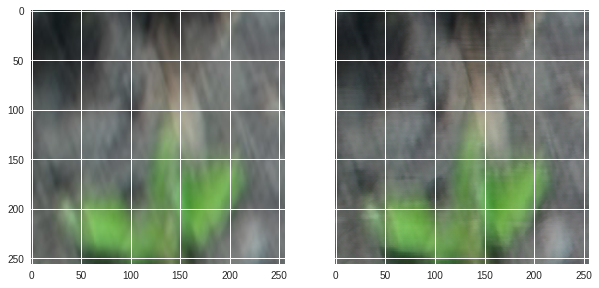

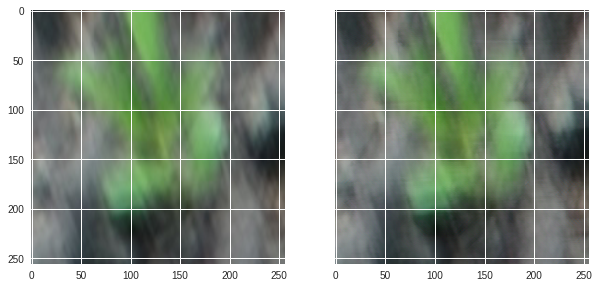

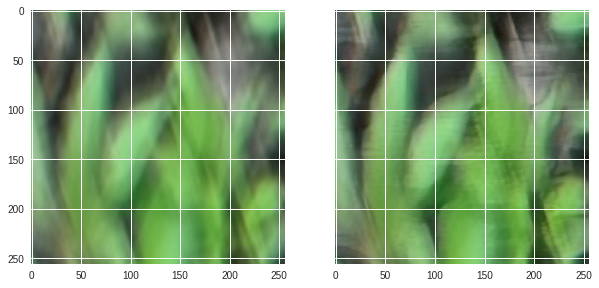

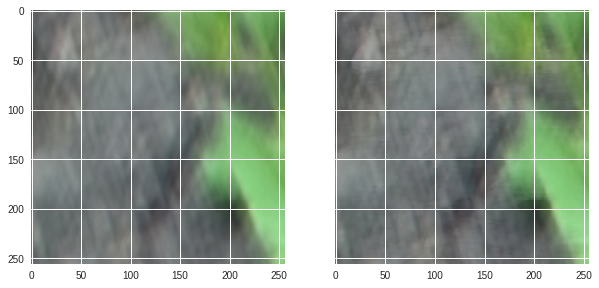

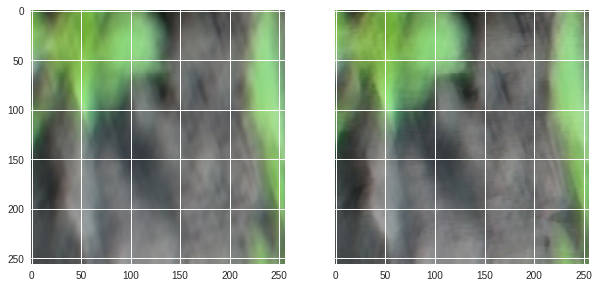

In [0]:
avgPSNR = 0.0
avgSSIM = 0.0
counter = 0

for i, data in enumerate(test_dataloader):
  if i >= 5:
    break
  
  total = i
  gpu_ids = [0]
  image_path = data['A_paths']
  
  # Set input as the blurred part of the test data
  input_blurred = torch.cuda.FloatTensor(1, 3, 256, 256)
  input_blurred = data['A']
  temp = input_blurred.clone()
  temp.resize_(input_blurred.size()).copy_(input_blurred)
  input_blurred = temp.cuda()
  
  # Set the generator
  netG = getGenerator(3, 3, 64, gpu_ids, True, True)
  state_dict = torch.load('latest_net_G.pth')

  # begin fix for mismatched keys : https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/296
  unexpecteds = ["model.10.conv_block.6.weight", "model.10.conv_block.6.bias", 
              "model.11.conv_block.6.weight", "model.11.conv_block.6.bias", 
              "model.12.conv_block.6.weight", "model.12.conv_block.6.bias", 
              "model.13.conv_block.6.weight", "model.13.conv_block.6.bias", 
              "model.14.conv_block.6.weight", "model.14.conv_block.6.bias", 
              "model.15.conv_block.6.weight", "model.15.conv_block.6.bias", 
              "model.16.conv_block.6.weight", "model.16.conv_block.6.bias", 
              "model.17.conv_block.6.weight", "model.17.conv_block.6.bias", 
              "model.18.conv_block.6.weight", "model.18.conv_block.6.bias"]
  missings = ["model.10.conv_block.5.weight", "model.10.conv_block.5.bias", 
                 "model.11.conv_block.5.weight", "model.11.conv_block.5.bias", 
                 "model.12.conv_block.5.weight", "model.12.conv_block.5.bias", 
                 "model.13.conv_block.5.weight", "model.13.conv_block.5.bias", 
                 "model.14.conv_block.5.weight", "model.14.conv_block.5.bias", 
                 "model.15.conv_block.5.weight", "model.15.conv_block.5.bias", 
                 "model.16.conv_block.5.weight", "model.16.conv_block.5.bias", 
                 "model.17.conv_block.5.weight", "model.17.conv_block.5.bias", 
                 "model.18.conv_block.5.weight", "model.18.conv_block.5.bias"]
  for i in range(len(missings)):
      state_dict[missings[i]] = state_dict.pop(unexpecteds[i])
  # end fix
    
  netG.load_state_dict(state_dict)  
    
  # Forward the blurred image through the Generator network
  real_blurred = Variable(input_blurred, volatile=True)
  fake_sharp = netG.forward(real_blurred)
  
  # Visualize the outputs
  real_blurred_data = tensor2im(real_blurred.data)
  fake_sharp_data = tensor2im(fake_sharp.data)
  
  # display the train blurred and sharp pair images
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
  ax1.set_label("Original Blurred Image")
  ax1.imshow(real_blurred_data)
  ax2.set_label("Generated Sharp Image")
  ax2.imshow(fake_sharp_data)
  
  # Calculate the metrics on the test data
  tpsnr = PSNR(fake_sharp_data,real_blurred_data)
  avgPSNR += tpsnr
  tssim = SSIM(fake_sharp_data,real_blurred_data)               #disable gpu and run on cpu for test if you get gpu OOM or Cuda error
  avgSSIM += tssim
  print("SSIM: PSNR: ", tssim, tpsnr)
  
  print('Processing image at %s ...' % image_path)

avgPSNR /= total
avgSSIM /= total
print('\n\n\n Average PSNR = %f, Average SSIM = %f' % (avgPSNR, avgSSIM))